In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import topcorr as tpc
import networkx as nx
import pingouin as pg

import bct
import enlighten

from os.path import join
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [61]:
def unvectorize_r(df, networks):
    corrmat = np.zeros((len(networks), len(networks)))
    for ntwk1 in networks:
        i = networks.index(ntwk1)
        for ntwk2 in networks:
            j = networks.index(ntwk2)
            var = f'rsfmri_c_ngd_{ntwk1}_ngd_{ntwk2}'
            try:
                corrmat[i,j] = np.tanh(df[var])
            except Exception as e:
                print(e)
    return corrmat

In [98]:
def residualize(X, y=None, confounds=None):
    '''
    all inputs need to be arrays, not dataframes
    '''
    # residualize the outcome
    if confounds is not None:
        if y is not None:
            temp_y = np.reshape(y, (y.shape[0],))
            y = pg.linear_regression(confounds, temp_y)
            resid_y = y.residuals_

            # residualize features
            resid_X = np.zeros_like(X)
            # print(X.shape, resid_X.shape)
            for i in range(0, X.shape[1]):
                X_temp = X[:, i]
                # print(X_temp.shape)
                X_ = pg.linear_regression(confounds, X_temp)
                # print(X_.residuals_.shape)
                resid_X[:, i] = X_.residuals_.flatten()
            return resid_y, resid_X
        else:
            # residualize features
            resid_X = np.zeros_like(X)
            # print(X.shape, resid_X.shape)
            for i in range(0, X.shape[1]):
                X_temp = X[:, i]
                # print(X_temp.shape)
                X_ = pg.linear_regression(confounds, X_temp)
                # print(X_.residuals_.shape)
                resid_X[:, i] = X_.residuals_.flatten()
            return resid_X

In [2]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [3]:
df = pd.read_pickle(join(PROJ_DIR, DATA_DIR, "data_qcd.pkl"))

ppts = df.filter(regex="rsfmri_c_ngd.*change_score").dropna().index

rsfc = pd.read_csv(
    "/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/Data/release5.0/core/imaging/mri_y_rsfmr_cor_gp_gp.csv",
    header=0,
    index_col=[0,1]
).dropna()


In [252]:
rs_motion = pd.read_csv(
    "/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/Data/release5.0/core/imaging/mri_y_qc_motion.csv",
    header=0,
    index_col=[0,1]
).dropna()

In [262]:
base_mot = rs_motion.swaplevel(axis=0).loc['baseline_year_1_arm_1'].filter(like='rsfmri').drop(['rsfmri_numtrs', 'rsfmri_nvols', 'rsfmri_tr'], axis=1)
y2fu_mot = rs_motion.swaplevel(axis=0).loc['2_year_follow_up_y_arm_1'].filter(like='rsfmri').drop(['rsfmri_numtrs', 'rsfmri_nvols', 'rsfmri_tr'], axis=1)
y4fu_mot = rs_motion.swaplevel(axis=0).loc['4_year_follow_up_y_arm_1'].filter(like='rsfmri').drop(['rsfmri_numtrs', 'rsfmri_nvols', 'rsfmri_tr'], axis=1)

In [428]:
base_ppts = list(set(base_mot[base_mot['rsfmri_subthreshnvols'] >= 750.].index) & set(base_mot[base_mot['rsfmri_meanmotion'] < 0.2].index))
y2fu_ppts = list(set(y2fu_mot[y2fu_mot['rsfmri_subthreshnvols'] >= 750.].index) & set(y2fu_mot[y2fu_mot['rsfmri_meanmotion'] < 0.2].index))
y4fu_ppts = list(set(y4fu_mot[y4fu_mot['rsfmri_subthreshnvols'] >= 750.].index) & set(y4fu_mot[y4fu_mot['rsfmri_meanmotion'] < 0.2].index))

In [429]:
len(set(base_ppts) & set(y2fu_ppts) & set(y4fu_ppts))

763

In [297]:
tpts = [
    'baseline_year_1_arm_1',
    '2_year_follow_up_y_arm_1',
    '4_year_follow_up_y_arm_1'
]

In [298]:
nones = list(rsfc.filter(regex='rsfmri_c_ngd_.*_ngd_n').columns) + list(rsfc.filter(regex='rsfmri_c_ngd_n_.*').columns)
rsfc = rsfc.drop(nones, axis=1)

In [299]:
within_network = [i for i in rsfc.columns if i.split('_')[3] == i.split('_')[5]]
within_network = list(set(within_network) - set(['n']))

btwn = rsfc.columns

network_wise = {}

for i in [j.split('_')[3] for j in within_network]:
    network_wise[i] = [k for k in btwn if i == k.split('_')[3]]

between_network = [i for i in rsfc.columns if i.split('_')[3] != i.split('_')[5]]

conns = rsfc.columns

base_df = rsfc.swaplevel(axis=0).loc['baseline_year_1_arm_1']
y2fu_df = rsfc.swaplevel(axis=0).loc['2_year_follow_up_y_arm_1']
y4fu_df = rsfc.swaplevel(axis=0).loc['4_year_follow_up_y_arm_1']


graph_measures = [
    'global_efficiency', 
    'modularity'
]

cols = pd.MultiIndex.from_product((tpts,graph_measures))
graph_df = pd.DataFrame(
    index=base_df.index, 
    columns=cols,
    dtype=float
)

cols = pd.MultiIndex.from_product((tpts,list(network_wise.keys())))
local_df = pd.DataFrame(
    index=base_df.index, 
    columns=cols,
    dtype=float
)

no_2yfu = []

In [434]:
motion_cols = base_mot.filter(like='mean').columns

In [ ]:
# I'm not sure residualizing is our best bet here
# because we're trying to describe the distributions
# and residualizing mean-centers the distributions

base_df = pd.concat([base_df,base_mot[motion_cols]], axis=1).dropna()
y2fu_df = pd.concat([y2fu_df,y2fu_mot[motion_cols]], axis=1).dropna()
y4fu_df = pd.concat([y4fu_df,y4fu_mot[motion_cols]], axis=1).dropna()

base_resid = residualize(base_df.drop(motion_cols, axis=1).values, confounds=base_df[motion_cols].values)
y2fu_resid = residualize(y2fu_df.drop(motion_cols, axis=1).values, confounds=y2fu_df[motion_cols].values)
y4fu_resid = residualize(y4fu_df.drop(motion_cols, axis=1).values, confounds=y4fu_df[motion_cols].values)

base_resid = pd.DataFrame(base_resid, index=base_df.index, columns=base_df.drop(motion_cols, axis=1).columns)
y2fu_resid = pd.DataFrame(y2fu_resid, index=y2fu_df.index, columns=y2fu_df.drop(motion_cols, axis=1).columns)
y4fu_resid = pd.DataFrame(y4fu_resid, index=y4fu_df.index, columns=y4fu_df.drop(motion_cols, axis=1).columns)

In [300]:
manager = enlighten.get_manager()
tocks = manager.counter(total=len(base_resid.index), desc='Progress', unit='ppts')


for ppt in base_ppts:
    try:
        corrmat = unvectorize_r(base_df.loc[ppt], list(network_wise.keys()))
        A = tpc.tmfg(corrmat, absolute=True, threshold_mean=True)
        A = nx.to_numpy_array(A)
        ntwk_df = pd.DataFrame(
            A,
            columns=list(network_wise.keys()), 
            index=list(network_wise.keys())
            )
        for ntwk in list(network_wise.keys()):
            local_df.at[ppt, (tpts[0], ntwk)] = ntwk_df[ntwk].sum()
        graph_df.at[ppt, (tpts[0], 'modularity')] = bct.modularity_louvain_und_sign(A)[1]
        #A = bct.threshold_proportional(corrmat, 0.5)
        graph_df.at[ppt, (tpts[0], 'global_efficiency')] = bct.efficiency_bin(A)
    except:
        no_2yfu.append(ppt)
for ppt in y2fu_ppts:
    try:
        corrmat = unvectorize_r(y2fu_df.loc[ppt], list(network_wise.keys()))
        A = tpc.tmfg(corrmat, absolute=True, threshold_mean=True)
        A = nx.to_numpy_array(A)
        ntwk_df = pd.DataFrame(
            A,
            columns=list(network_wise.keys()), 
            index=list(network_wise.keys())
            )
        for ntwk in list(network_wise.keys()):
            local_df.at[ppt, (tpts[1], ntwk)] = ntwk_df[ntwk].sum()
        graph_df.at[ppt, (tpts[1], 'modularity')] = bct.modularity_louvain_und_sign(A)[1]
        #A = bct.threshold_proportional(corrmat, 0.5)
        graph_df.at[ppt, (tpts[1], 'global_efficiency')] = bct.efficiency_bin(A)
    except:
        no_2yfu.append(ppt)
for ppt in y4fu_ppts:
    try:
        corrmat = unvectorize_r(y4fu_df.loc[ppt], list(network_wise.keys()))
        A = tpc.tmfg(corrmat, absolute=True, threshold_mean=True)
        A = nx.to_numpy_array(A)
        ntwk_df = pd.DataFrame(
            A,
            columns=list(network_wise.keys()), 
            index=list(network_wise.keys())
            )
        for ntwk in list(network_wise.keys()):
            local_df.at[ppt, (tpts[2], ntwk)] = ntwk_df[ntwk].sum()
        graph_df.at[ppt, (tpts[2], 'modularity')] = bct.modularity_louvain_und_sign(A)[1]
        #A = bct.threshold_proportional(corrmat, 0.5)
        graph_df.at[ppt, (tpts[2], 'global_efficiency')] = bct.efficiency_bin(A)
    except:
        no_2yfu.append(ppt)

In [301]:
graph_df.isna().sum()

baseline_year_1_arm_1     global_efficiency    9020
                          modularity           9020
2_year_follow_up_y_arm_1  global_efficiency    8770
                          modularity           8770
4_year_follow_up_y_arm_1  global_efficiency    9843
                          modularity           9843
dtype: int64

In [302]:
no_2yfu

['NDAR_INV7F1N85W0',
 'NDAR_INVLN9ZEHNH',
 'NDAR_INVNPTLFHLG',
 'NDAR_INV8YPT1XL0',
 'NDAR_INV23XZD51D',
 'NDAR_INVXWDXTUZ0',
 'NDAR_INVDAYVFF0J',
 'NDAR_INVTFRWPXDT',
 'NDAR_INVR7G6JDFU',
 'NDAR_INVV4KUL4N2',
 'NDAR_INVNX6AEDBV',
 'NDAR_INV7ATXXJUG']

In [303]:
long_graph = graph_df.melt(var_name=['visit', 'metric'])
long_local = local_df.melt(var_name=['visit', 'network'])

long_mod = long_graph[long_graph['metric'] == 'modularity']
long_eff = long_graph[long_graph['metric'] == 'global_efficiency']

In [304]:
long_local1 = local_df.dropna().melt(var_name=['visit', 'network'])

In [319]:
long_local

,visit,network,value
0,baseline_year_1_arm_1,dla,NaN
1,baseline_year_1_arm_1,dla,NaN
2,baseline_year_1_arm_1,dla,-0.101048
3,baseline_year_1_arm_1,dla,NaN
4,baseline_year_1_arm_1,dla,NaN
...,...,...,...
406723,4_year_follow_up_y_arm_1,fo,-0.241675
406724,4_year_follow_up_y_arm_1,fo,-0.047531
406725,4_year_follow_up_y_arm_1,fo,-0.103739
406726,4_year_follow_up_y_arm_1,fo,-0.473368


In [355]:
# try this with absolute values
hue_order = list(np.abs(local_df.mean().loc['baseline_year_1_arm_1'].sort_values()).index)

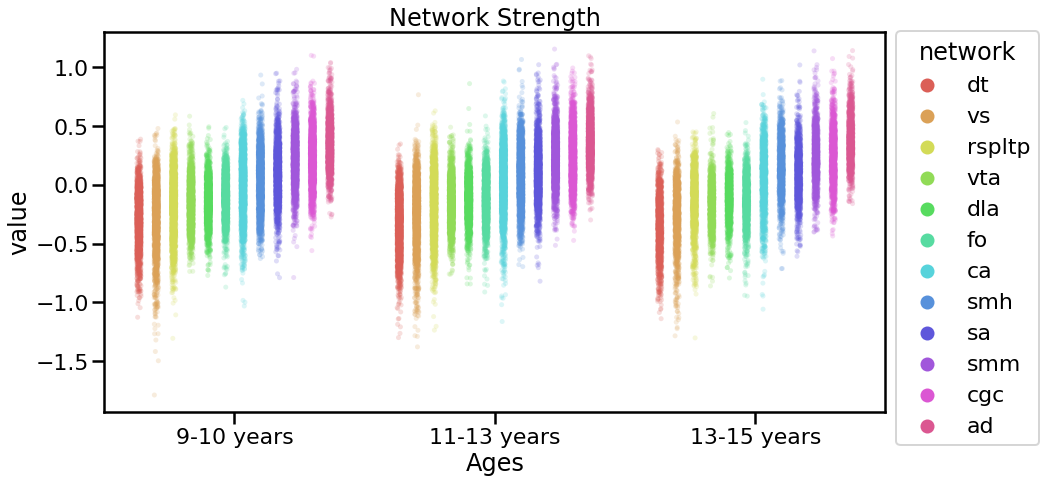

In [364]:
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(14,7))
sns.stripplot(
    long_local, 
    y='value',
    x='visit',
    hue='network',
    hue_order=hue_order,
    dodge=True, 
    #errorbar='sd',
    ax=ax,
    palette='hls',
    alpha=0.2
)
ax.set_title('Network Strength')
ax.set_xlabel('Ages')
ax.set_xticklabels(['9-10 years', '11-13 years', '13-15 years'])

legend = ax.get_legend()
legend.set_bbox_to_anchor((1,1.03))
#ax.axvline(long_mod[long_mod['visit'] == 'baseline_year_1_arm_1'])
#fig.savefig(
#    join(PROJ_DIR, FIGS_DIR, 'delta_rsFC-network_strength_base-2yfu.png'), 
#    dpi=400, 
#    bbox_inches='tight',
#    facecolor='#FFFFFF',
#)

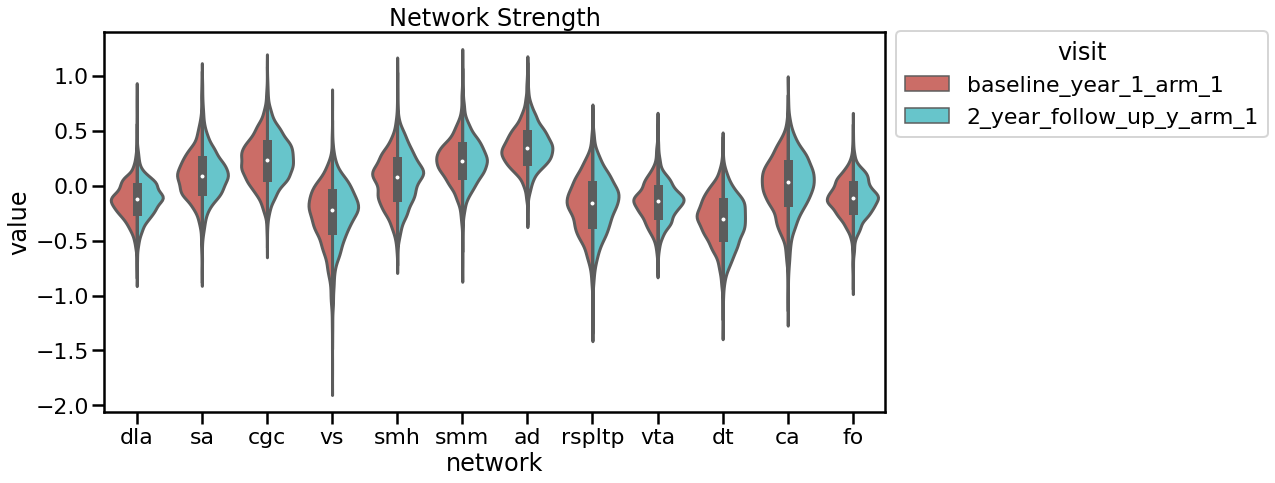

In [379]:
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(14,7))
sns.violinplot(
    long_local[long_local['visit'] != '4_year_follow_up_y_arm_1'], 
    y='value',
    x='network',
    hue='visit',
    #inner='quartile',
    split=True,
    #hue_order=hue_order,
    #dodge=True, 
    #errorbar='sd',
    ax=ax,
    palette='hls',
    alpha=0.2
)
ax.set_title('Network Strength')
#ax.set_xlabel('Ages')
#ax.set_xticklabels(['9-10 years', '11-13 years', '13-15 years'])

legend = ax.get_legend()
legend.set_bbox_to_anchor((1,1.03))
#ax.axvline(long_mod[long_mod['visit'] == 'baseline_year_1_arm_1'])
#fig.savefig(
#    join(PROJ_DIR, FIGS_DIR, 'delta_rsFC-network_strength_base-2yfu.png'), 
#    dpi=400, 
#    bbox_inches='tight',
#    facecolor='#FFFFFF',
#)

In [368]:
long_local[long_local['visit'] != '4_year_follow_up_y_arm_1']['visit'].unique()

array(['baseline_year_1_arm_1', '2_year_follow_up_y_arm_1'], dtype=object)

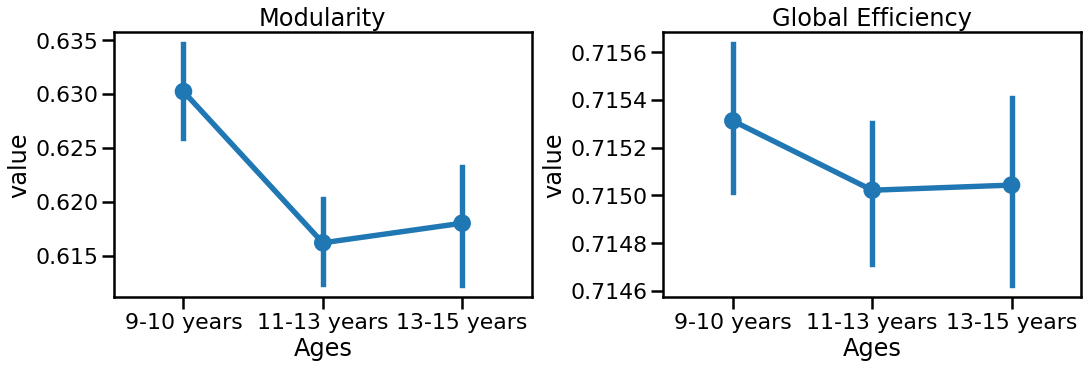

In [381]:
fig,ax = plt.subplots(ncols=2, figsize=(15,5), layout='constrained')
sns.pointplot(
    long_mod, 
    y='value',
    x='visit',
    errorbar=('ci', 95),
    #hue='visit', 
    #multiple='stack', 
    ax=ax[0]
)
sns.pointplot(
    long_eff, 
    y='value',
    x='visit',
    errorbar=('ci', 95),
    #hue='visit', 
    #multiple='stack', 
    ax=ax[1]
)
ax[0].set_title('Modularity')
ax[1].set_title('Global Efficiency')

ax[0].set_xlabel('Ages')
ax[1].set_xlabel('Ages')

ax[0].set_xticklabels(['9-10 years', '11-13 years', '13-15 years'])
ax[1].set_xticklabels(['9-10 years', '11-13 years', '13-15 years'])
plt.show()
#ax.axvline(long_mod[long_mod['visit'] == 'baseline_year_1_arm_1'])
fig.savefig(
    join(PROJ_DIR, FIGS_DIR, 'delta_rsFC-graph_theory_base-2yfu.png'), 
    dpi=400, 
    bbox_inches='tight',
    facecolor='#FFFFFF',
)


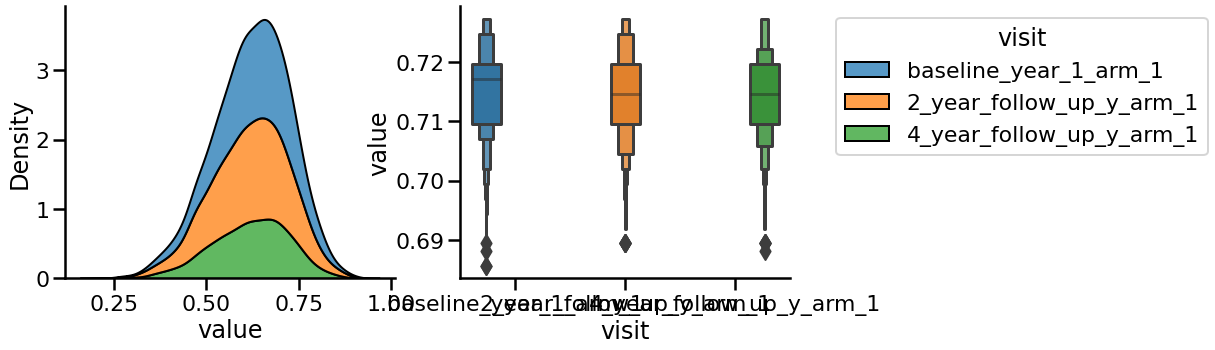

In [419]:
fig,ax = plt.subplots(ncols=2,figsize=(13,5))
sns.kdeplot(
    long_graph[long_graph['metric'] == 'modularity'],
    x='value',
    hue='visit',
    multiple='stack',
    ax=ax[0],
    common_norm=True
)



legend2 = ax[1].get_legend()
legend2.remove()

legend = ax[0].get_legend()
legend.set_bbox_to_anchor((3.5,1))

sns.despine()

<AxesSubplot:xlabel='visit', ylabel='value'>

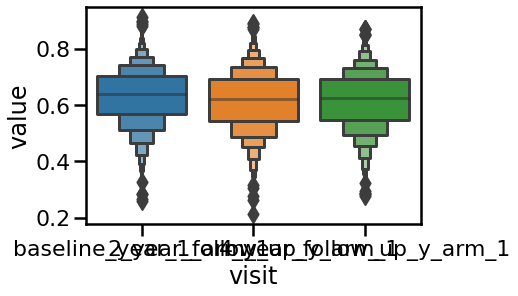

In [422]:
sns.boxenplot(
    long_graph[long_graph['metric'] == 'modularity'],
    y='value',
    x='visit',
    #hue='visit',
    #multiple='stack',
    #ax=ax[1],
    #common_norm=True
)

<AxesSubplot:>

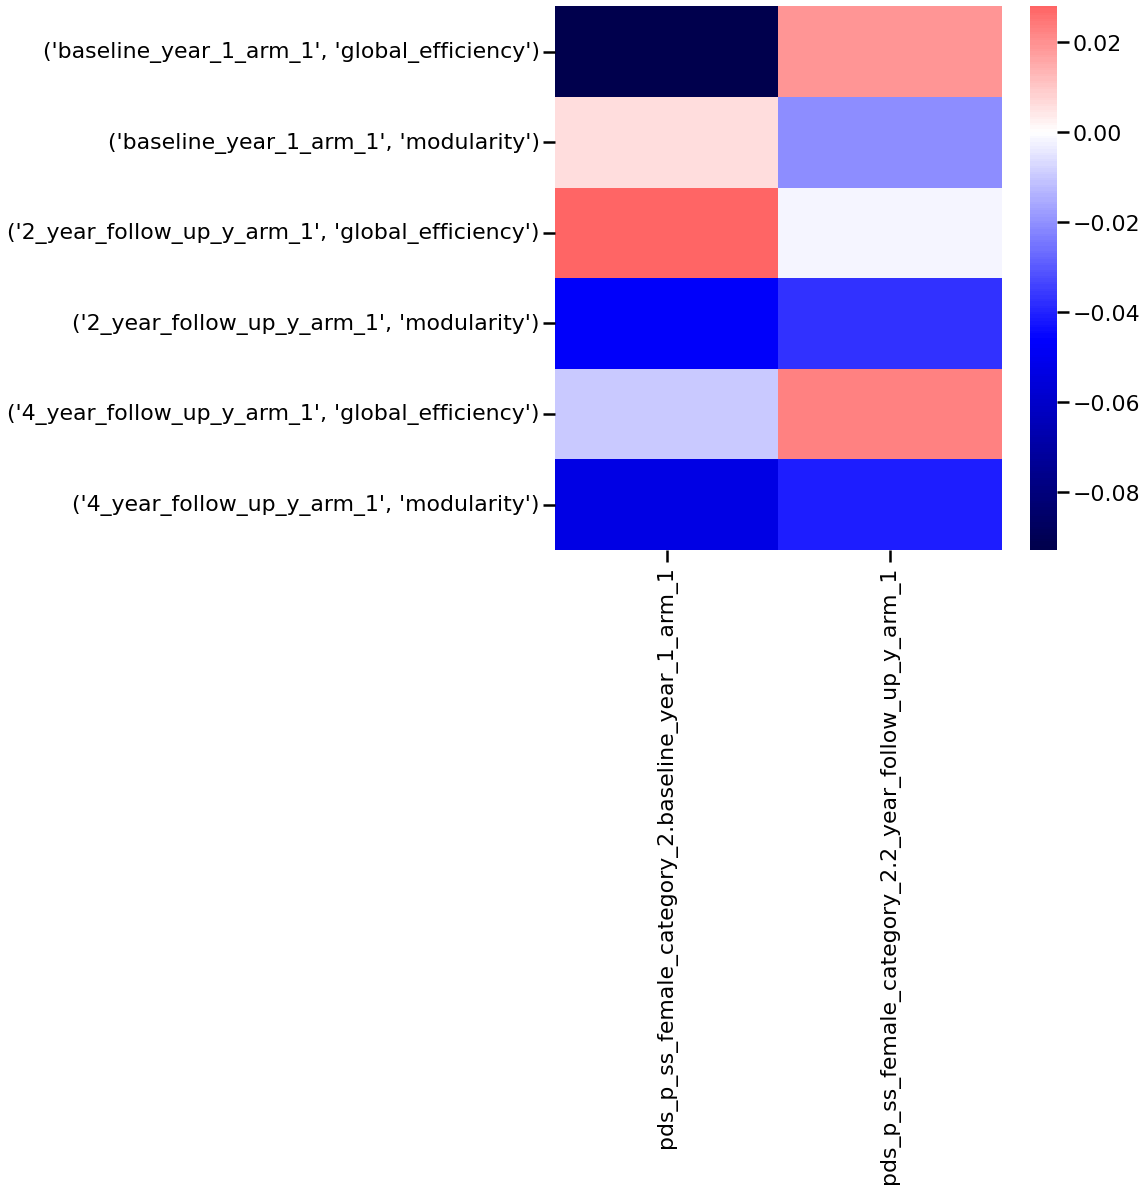

In [388]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    pd.concat([graph_df, df.filter(like='pds')], axis=1).corr().filter(like='pds_p_ss_female').iloc[:-4], 
    cmap='seismic', 
    center=0,
)

In [309]:
puberty_corrs = pd.concat([local_df, df.filter(like='pds')], axis=1).corr().filter(like='pds').iloc[:-4]

In [310]:
puberty_corrs.sort_values('pds_p_ss_female_category_2.baseline_year_1_arm_1')

,pds_p_ss_female_category_2.baseline_year_1_arm_1,pds_p_ss_male_category_2.baseline_year_1_arm_1,pds_p_ss_male_category_2.2_year_follow_up_y_arm_1,pds_p_ss_female_category_2.2_year_follow_up_y_arm_1
"(4_year_follow_up_y_arm_1, vta)",-0.055824,0.074049,-0.040216,-0.042875
"(baseline_year_1_arm_1, ca)",-0.051940,-0.021792,-0.075371,-0.042982
"(2_year_follow_up_y_arm_1, fo)",-0.043962,0.007058,0.007491,0.046458
"(baseline_year_1_arm_1, dt)",-0.040246,-0.023996,0.001419,-0.109313
"(2_year_follow_up_y_arm_1, sa)",-0.031160,-0.028885,-0.025423,-0.004074
"(2_year_follow_up_y_arm_1, vta)",-0.030489,0.009100,-0.056010,-0.047258
"(baseline_year_1_arm_1, sa)",-0.030050,-0.087054,-0.039517,-0.053769
"(2_year_follow_up_y_arm_1, dt)",-0.025763,0.072480,-0.000743,-0.016207
"(baseline_year_1_arm_1, cgc)",-0.003948,-0.000808,0.036381,-0.046388
"(4_year_follow_up_y_arm_1, ca)",-0.001293,-0.012860,-0.021557,-0.043013


In [218]:
puberty_corrs.filter(like='baseline', axis=0).sort_values('pds_p_ss_female_category_2.baseline_year_1_arm_1')

,pds_p_ss_female_category_2.baseline_year_1_arm_1,pds_p_ss_male_category_2.baseline_year_1_arm_1,pds_p_ss_male_category_2.2_year_follow_up_y_arm_1,pds_p_ss_female_category_2.2_year_follow_up_y_arm_1
"(baseline_year_1_arm_1, sa)",-0.080380,-0.051174,-0.029102,-0.076169
"(baseline_year_1_arm_1, ca)",-0.066327,-0.009491,-0.026894,-0.025467
"(baseline_year_1_arm_1, dt)",-0.049976,-0.052755,-0.034014,-0.033383
"(baseline_year_1_arm_1, vta)",-0.049475,-0.069214,-0.063691,-0.046763
"(baseline_year_1_arm_1, cgc)",-0.043694,-0.003166,-0.006767,-0.026594
"(baseline_year_1_arm_1, fo)",-0.038914,0.015881,0.020782,-0.028120
"(baseline_year_1_arm_1, ad)",-0.010342,0.025940,0.018134,-0.025442
"(baseline_year_1_arm_1, dla)",0.019649,0.061932,0.031469,0.033145
"(baseline_year_1_arm_1, smm)",0.022313,0.046293,0.001941,0.006814
"(baseline_year_1_arm_1, rspltp)",0.031068,0.029146,0.001323,0.042284


In [219]:
puberty_corrs.filter(like='2', axis=0).sort_values('pds_p_ss_female_category_2.baseline_year_1_arm_1')

,pds_p_ss_female_category_2.baseline_year_1_arm_1,pds_p_ss_male_category_2.baseline_year_1_arm_1,pds_p_ss_male_category_2.2_year_follow_up_y_arm_1,pds_p_ss_female_category_2.2_year_follow_up_y_arm_1
"(2_year_follow_up_y_arm_1, vta)",-0.090549,-0.083423,-0.103506,-0.104743
"(2_year_follow_up_y_arm_1, fo)",-0.035693,0.019611,0.036009,0.025875
"(2_year_follow_up_y_arm_1, sa)",-0.019911,0.000603,0.021692,-0.009580
"(2_year_follow_up_y_arm_1, dt)",-0.019010,0.029131,0.009929,-0.014022
"(2_year_follow_up_y_arm_1, ca)",0.020727,0.051075,0.048437,0.086679
"(2_year_follow_up_y_arm_1, cgc)",0.026393,0.018799,0.012783,0.037815
"(2_year_follow_up_y_arm_1, vs)",0.035962,0.029641,0.003878,0.036871
"(2_year_follow_up_y_arm_1, ad)",0.040559,0.038210,0.010417,0.010382
"(2_year_follow_up_y_arm_1, rspltp)",0.059977,0.046550,0.021088,0.063053
"(2_year_follow_up_y_arm_1, dla)",0.062499,0.003839,0.046843,0.070720
